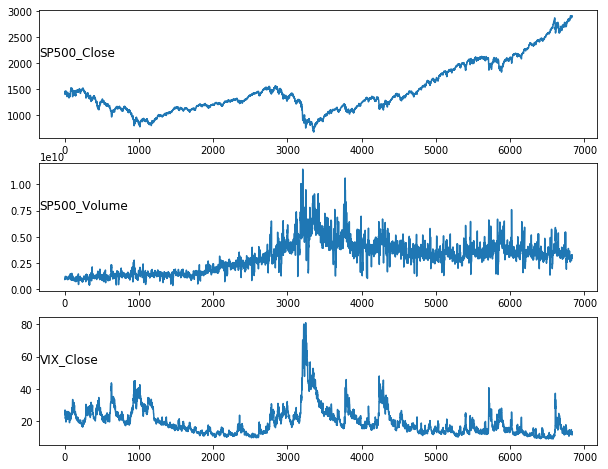

   var1(t-1)  var2(t-1)  var3(t-1)  var1(t+1)  var2(t+1)  var3(t+1)
1   0.348016   0.051867   0.210123   0.348016   0.051867   0.210123
2   0.348016   0.051867   0.210123   0.323078   0.058912   0.249163
3   0.348016   0.051867   0.210123   0.324280   0.065713   0.240798
4   0.323078   0.058912   0.249163   0.324879   0.066326   0.231316
5   0.324280   0.065713   0.240798   0.341871   0.078299   0.175404
   var1(t-1)  var2(t-1)  var3(t-1)  var1(t+1)
1   0.348016   0.051867   0.210123   0.348016
2   0.348016   0.051867   0.210123   0.323078
3   0.348016   0.051867   0.210123   0.324280
4   0.323078   0.058912   0.249163   0.324879
5   0.324280   0.065713   0.240798   0.341871
Train on 5468 samples, validate on 1367 samples
Epoch 1/200
 - 4s - loss: 0.1544 - val_loss: 0.3879
Epoch 2/200
 - 0s - loss: 0.0843 - val_loss: 0.3400
Epoch 3/200
 - 0s - loss: 0.0755 - val_loss: 0.3061
Epoch 4/200
 - 0s - loss: 0.0679 - val_loss: 0.2685
Epoch 5/200
 - 0s - loss: 0.0612 - val_loss: 0.2293
Epoch 6/

 - 0s - loss: 0.0058 - val_loss: 0.0080
Epoch 142/200
 - 0s - loss: 0.0059 - val_loss: 0.0075
Epoch 143/200
 - 0s - loss: 0.0058 - val_loss: 0.0074
Epoch 144/200
 - 0s - loss: 0.0055 - val_loss: 0.0072
Epoch 145/200
 - 0s - loss: 0.0059 - val_loss: 0.0077
Epoch 146/200
 - 0s - loss: 0.0054 - val_loss: 0.0068
Epoch 147/200
 - 0s - loss: 0.0061 - val_loss: 0.0076
Epoch 148/200
 - 0s - loss: 0.0057 - val_loss: 0.0074
Epoch 149/200
 - 0s - loss: 0.0055 - val_loss: 0.0074
Epoch 150/200
 - 0s - loss: 0.0058 - val_loss: 0.0071
Epoch 151/200
 - 0s - loss: 0.0057 - val_loss: 0.0074
Epoch 152/200
 - 0s - loss: 0.0055 - val_loss: 0.0066
Epoch 153/200
 - 0s - loss: 0.0059 - val_loss: 0.0074
Epoch 154/200
 - 0s - loss: 0.0055 - val_loss: 0.0073
Epoch 155/200
 - 0s - loss: 0.0058 - val_loss: 0.0070
Epoch 156/200
 - 0s - loss: 0.0057 - val_loss: 0.0068
Epoch 157/200
 - 0s - loss: 0.0058 - val_loss: 0.0073
Epoch 158/200
 - 0s - loss: 0.0056 - val_loss: 0.0070
Epoch 159/200
 - 0s - loss: 0.0058 - val_l

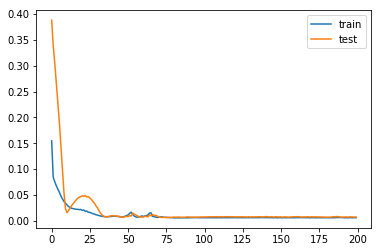

[2082.17 2081.88 2081.88 ... 2888.8  2904.31 2907.95]
RMSE Result: 22.88819


In [60]:
from numpy import *
from pandas import *
from matplotlib import pyplot
from pandas import read_csv
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import *
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

%matplotlib inline

# convert time series to supervised learning
# Using one lag observation as input (x)
# Using one observation as output (y)
def convert_ts_to_supervised(data_in):
    n_vars = 1 if type(data_in) is list else data.shape[1]
    df = DataFrame(data_in)
    y = list()
    names = list()
    # Build input sequence
    y.append(df.shift(1))
    names += [('var%d(t-%d)' % (j+1, 1)) for j in range(n_vars)]
    
    # Build forecast sequence 
    y.append(df.shift(-1))
    names += [('var%d(t+%d)' % (j+1, 1)) for j in range(n_vars)]
    
    # Combine input and forecast sequence
    combined_data = concat(y, axis=1)
    combined_data.columns = names

    # Remove missing values
    combined_data.dropna(inplace=True)
    return combined_data

def plot_features(data):
    # Plot only the features:
    # sp500_close price, sp500_volume, VIX_close price
    num_features = [0, 1, 2]
    i = 1
    pyplot.figure(figsize=(10,8))
    for n in num_features:
        pyplot.subplot(len(num_features), 1, i)
        pyplot.plot(values[:, n])
        pyplot.title(data.columns[n], y=0.6, loc='left')
        i += 1
    pyplot.show()

# load data
path = 'C:/analytics/'
data = read_csv(path + 'SP500_VIX.csv', index_col=0)

# Set Date as index column
data.index.name = 'Date'

values = data.values
plot_features(data)

# Set all data as float
values = values.astype('float32')

# Feature engineering: normalize and transform
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Convert time series to supervised learning
reframed = convert_ts_to_supervised(scaled)
print(reframed.head())

# Predict only y=SP500_Close(t+1)
# Drop columns SP500_volume(t+1) and VIX_Close(t+1)
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

# Split into 80% train and 20% test data
values = reframed.values
train_80pct = int(len(values)* 0.8)

train = values[:train_80pct, :]
test = values[train_80pct:, :]

# Split training and test data into input(x) and output(y)
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Reshape for LSTM network: [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# Design network and fit the model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
fitted = model.fit(train_X, train_y, epochs=200, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# Plot istory
pyplot.plot(fitted.history['loss'], label='train')
pyplot.plot(fitted.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# Predict SP500 Close Price
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Reverse scaling to get actual value
test_y = test_y.reshape((len(test_y), 1))
rev_y = concatenate((test_y, test_X[:, 1:]), axis=1)
rev_y = scaler.inverse_transform(rev_y)
rev_y = rev_y[:,0]
print (rev_y)

# Calculate and print RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('RMSE Result: %.5f' % rmse)